In [123]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

from sympy.physics.quantum import TensorProduct


In [124]:
def prune_zero_rows_cols(M: sp.Matrix) -> sp.Matrix:
    """
    Remove all‑zero rows and columns from a Sympy matrix M.

    Returns the smaller submatrix containing only rows/columns
    that have at least one non‑zero entry.
    """
    # indices of rows that are not all zero
    nonzero_rows = [i for i in range(M.rows)
                    if any(M[i, j] != 0 for j in range(M.cols))]
    # indices of cols that are not all zero
    nonzero_cols = [j for j in range(M.cols)
                    if any(M[i, j] != 0 for i in range(M.rows))]
    # extract the submatrix
    return M.extract(nonzero_rows, nonzero_cols)

def com(X: sp.Matrix, Y: sp.Matrix) -> sp.Matrix:
    """
    The “adjoint action” commutator [X,Y] = X*Y - Y*X.
    """
    return X*Y - Y*X

U, phi, K, q = sp.symbols('U phi K q', positive=True)

H0_1 = sp.Matrix([[0,sp.exp(sp.I * phi) + sp.exp(-sp.I * (K/2-q)), 1 + sp.exp(-sp.I * (K/2-q))],
                [sp.exp(-sp.I * phi) + sp.exp(sp.I * (K/2-q)) ,0,0],
                [1 + sp.exp(sp.I * (K/2-q)) ,0,0]])

H0_2 = sp.Matrix([[0,sp.exp(sp.I * phi) + sp.exp(-sp.I * (K/2+q)), 1 + sp.exp(-sp.I * (K/2+q))],
                [sp.exp(-sp.I * phi) + sp.exp(sp.I * (K/2+q)) ,0,0],
                [1 + sp.exp(sp.I * (K/2+q)) ,0,0]])


T = TensorProduct(H0_1, sp.eye(3)) + TensorProduct(sp.eye(3),H0_2) 

_INTERACT = {0, 4, 8}

P = sp.Matrix(np.diag([1 if i in _INTERACT else 0 for i in range(0,9)]))
potential = U*P
Q = sp.eye(9)-P

H2 = 1/(2*U)* P@T@Q@T@P
H4 = 1/(8*U**3) * P@T@Q@T@Q@T@Q@T@P

H_eff = potential - H2 + H4

H_eff_red = prune_zero_rows_cols(H_eff)
H_eff_red = sp.simplify(H_eff_red)


In [121]:
H0_1

Matrix([
[                             0, exp(I*phi) + exp(-I*(K/2 - q)), 1 + exp(-I*(K/2 - q))],
[exp(I*(K/2 - q)) + exp(-I*phi),                              0,                     0],
[          exp(I*(K/2 - q)) + 1,                              0,                     0]])

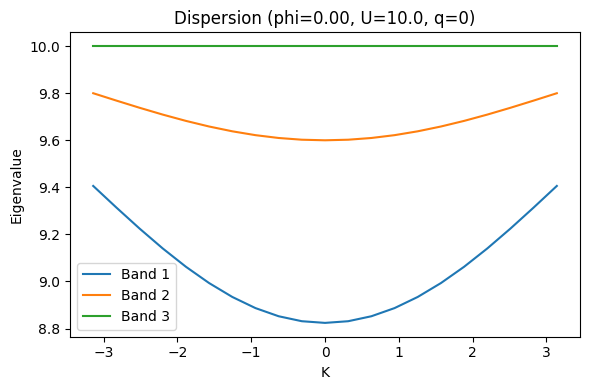

In [95]:
M_func = sp.lambdify((phi, U, K, q), H_eff_red, 'numpy')

# 3. Choose your fixed parameters and K‐grid:
phi_val = 0
U_val   = 10.0
q_val   = 0     # or whatever value you need
K_vals  = np.linspace(-np.pi, np.pi, 21)

# 4. Allocate array to hold the three eigenvalues at each K:
eigs = np.zeros((len(K_vals), 3), dtype=float)

# 5. Loop over K, evaluate matrix, diagonalize, sort:
for i, Kv in enumerate(K_vals):
    M_num = M_func(phi_val, U_val, Kv, q_val)
    # since M is Hermitian in your physical problem, use eigvalsh:
    ev = np.linalg.eigvalsh(M_num)
    eigs[i, :] = np.sort(ev.real)

# 6. Plot the three bands:
plt.figure(figsize=(6,4))
for band in range(3):
    plt.plot(K_vals, eigs[:, band], label=f'Band {band+1}')
plt.xlabel('K')
plt.ylabel('Eigenvalue')
plt.title(f'Dispersion (phi={phi_val:.2f}, U={U_val}, q={q_val})')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [96]:
V = T
H_U = potential

S = (P @ V @ Q - Q @ V @ P)/(2*U)
H = H_U + V
H1 =     com(S, H)
H2 = 1/2*com(S, H1)
H3 = 1/6*com(S, H2)
H4 = 1/24*com(S, H3)
Heff = P @ (H + H1 + H2 + H3 + H4) @ P

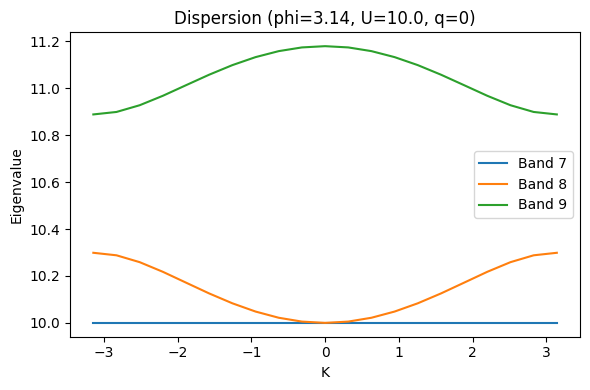

In [103]:
M_func = sp.lambdify((phi, U, K, q), Heff, 'numpy')

# 3. Choose your fixed parameters and K‐grid:
phi_val = np.pi
U_val   = 10.0
q_val   = 0     # or whatever value you need
K_vals  = np.linspace(-np.pi, np.pi, 21)

# 4. Allocate array to hold the three eigenvalues at each K:
eigs = np.zeros((len(K_vals), 9), dtype=float)

# 5. Loop over K, evaluate matrix, diagonalize, sort:
for i, Kv in enumerate(K_vals):
    M_num = M_func(phi_val, U_val, Kv, q_val)
    # since M is Hermitian in your physical problem, use eigvalsh:
    ev = np.linalg.eigvalsh(M_num)
    eigs[i, :] = np.sort(ev.real)

# 6. Plot the three bands:
plt.figure(figsize=(6,4))
for band in range(6,9):
    plt.plot(K_vals, eigs[:, band], label=f'Band {band+1}')
plt.xlabel('K')
plt.ylabel('Eigenvalue')
plt.title(f'Dispersion (phi={phi_val:.2f}, U={U_val}, q={q_val})')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [119]:
np.linalg.eigvalsh(M_func(phi, U_val, -np.pi, 0))

array([-1.36063276e-28, -2.46509885e-32,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  8.88178420e-16,  1.00000000e+01,  1.03782858e+01,
        1.13903808e+01])

In [120]:
np.linalg.eigvalsh(M_func(phi, U_val, np.pi, 0) )

array([-4.48250707e-17, -1.68895431e-24,  0.00000000e+00,  0.00000000e+00,
        1.87326525e-79,  2.34201937e-25,  1.00000000e+01,  1.00000000e+01,
        1.05947778e+01])

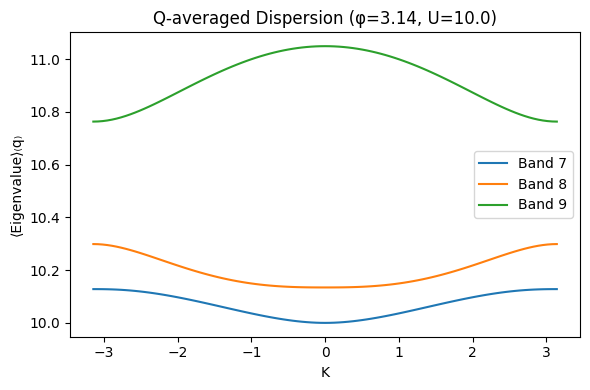

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# 1. Your lambdified effective‑Hamiltonian:
M_func = sp.lambdify((phi, U, K, q), Heff, 'numpy')

# 2. Fixed parameters:
phi_val = np.pi
U_val   = 10.0

# 3. Grids:
K_vals = np.linspace(-np.pi, np.pi, 101)    # e.g. 101 K points
Nq     = 51                                  # choose however many q’s you like
q_vals = np.linspace(-np.pi, np.pi, Nq)      # relative‑momentum grid

# 4. Preallocate: shape = (n_K, n_q, n_bands)
nK = len(K_vals)
nq = len(q_vals)
nB = 9    # number of bands / matrix size
eigs_qk = np.zeros((nK, nq, nB))

# 5. Fill the array
for i, Kv in enumerate(K_vals):
    for j, qv in enumerate(q_vals):
        M_num = M_func(phi_val, U_val, Kv, qv)
        ev = np.linalg.eigvalsh(M_num)
        eigs_qk[i, j, :] = np.sort(ev.real)

# 6. Average over q:
eigs_avg = eigs_qk.mean(axis=1)   # shape (nK, nB)

# 7. Plot the q‑averaged upper three bands (for example)
plt.figure(figsize=(6,4))
for band in range(6,9):
    plt.plot(K_vals, eigs_avg[:, band], label=f'Band {band+1}')
plt.xlabel('K')
plt.ylabel('⟨Eigenvalue⟩₍q₎')
plt.title(f'Q‑averaged Dispersion (φ={phi_val:.2f}, U={U_val})')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


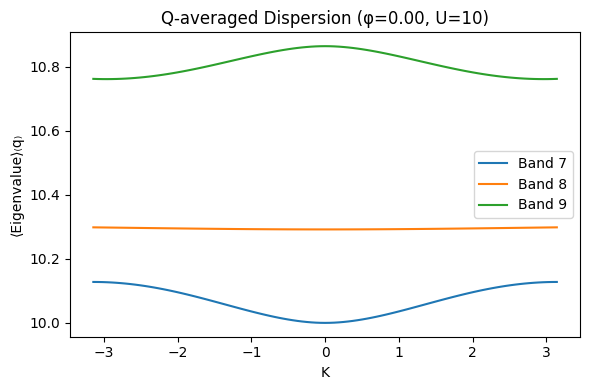

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# 1. Your lambdified effective‑Hamiltonian:
M_func = sp.lambdify((phi, U, K, q), Heff, 'numpy')

# 2. Fixed parameters:
phi_val = 0
U_val   = 10

# 3. Grids:
K_vals = np.linspace(-np.pi, np.pi, 101)    # e.g. 101 K points
Nq     = 51                                  # choose however many q’s you like
q_vals = np.linspace(-np.pi, np.pi, Nq)      # relative‑momentum grid

# 4. Preallocate: shape = (n_K, n_q, n_bands)
nK = len(K_vals)
nq = len(q_vals)
nB = 9    # number of bands / matrix size
eigs_qk = np.zeros((nK, nq, nB))

# 5. Fill the array
for i, Kv in enumerate(K_vals):
    for j, qv in enumerate(q_vals):
        M_num = M_func(phi_val, U_val, Kv, qv)
        ev = np.linalg.eigvalsh(M_num)
        eigs_qk[i, j, :] = np.sort(ev.real)

# 6. Average over q:
eigs_avg = eigs_qk.mean(axis=1)   # shape (nK, nB)

# 7. Plot the q‑averaged upper three bands (for example)
plt.figure(figsize=(6,4))
for band in range(6,9):
    plt.plot(K_vals, eigs_avg[:, band], label=f'Band {band+1}')
plt.xlabel('K')
plt.ylabel('⟨Eigenvalue⟩₍q₎')
plt.title(f'Q‑averaged Dispersion (φ={phi_val:.2f}, U={U_val})')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
